In [39]:
#%%
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import subprocess
from datetime import timedelta
from cht_hurrywave.hurrywave import HurryWave
from cht_hurrywave.grid import HurryWaveGrid
# note, we don't use the Mask class from the mask.py nor the grid from grid.py! Instead, both from hurrywave_domain
from cht_utils.geometry import RegularGrid
from cht_hurrywave.hurrywave_builder import HurryWaveBuilder
# from cht_hurrywave.bathymetry import HurryWaveBathymetry
# from cht_hurrywave.mask import HurryWaveMask
# from cht_bathymetry.database import BathymetryDatabase
from cht_model_builder.model_builder import MaskPolygon
from cht_utils.pli_file import read_pli_file
from cht_meteo.meteo import MeteoGrid
from pyproj import CRS 
import geopandas as gpd
from shapely.geometry import Polygon

import subprocess
import threading
import time


In [40]:
#%%
main_path  = os.path.join(r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest') 
if not os.path.exists(main_path):
    os.mkdir(main_path)

model_setup = os.path.join(main_path, '04_modelruns', 'NorthSeanobnd')

if not os.path.exists(model_setup):
    os.mkdir(model_setup)

print('Model setup path:', model_setup)
hw = HurryWave(path=model_setup)




Model setup path: C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\NorthSeanobnd


In [ ]:
# Configure inputs
specs = {
    'mmax': 421,
    'nmax': 481,
    'dx': 0.05,
    'dy': 0.033333333,
    'x0': -12,
    'y0': 48,
    'rotation': 0.0,
    'latitude': 0.0,
    'tref': "20131201 000000",
    'tstart': "20131201 000000",
    'tstop': "20131208 000000",
    'dt': 300,
    'tspinup': 1800.0,
    't0out': -999.0,
    'dtmapout': 1800,
    'dthisout': 300,
    'dtrstout': 0.0,
    'dtsp2out': 3600.0,
    'dtmaxout': 0.0,
    'trstout': -999.0,
    'dtwnd': 1800.0,
    'rhoa': 1.25,
    'rhow': 1024.0,
    'dmx1': 0.2,
    'dmx2': 1e-05,
    'crsgeo': 0,
    'freqmin': 0.04,
    'freqmax': 0.5,
    'nsigma': 12,
    'ntheta': 36,
    'crs_name': "WGS 84",
    'crs_type': "geographic",
    'gammajsp': 3.3,
    'spinup_meteo': 1,
    'quadruplets': 1,
    'redopt': 1,
    'winddrag': "zijlema",
    'cdcap': 0.0025,
    'depfile': "hurrywave.dep",
    'mskfile': "hurrywave.msk",
    'bndfile': "hurrywave.bnd",
    'bhsfile': "hurrywave.bhs",
    'btpfile': "hurrywave.btp",
    'bwdfile': "hurrywave.bwd",
    'bdsfile': "hurrywave.bds",
    'amufile': "wind.amu",
    'amvfile': "wind.amv",
    'obsfile': "hurrywave.obs",
    'inputformat': "bin",
    'outputformat': "net"
}


hw.input.update(specs)

In [42]:
# Observation points


eof


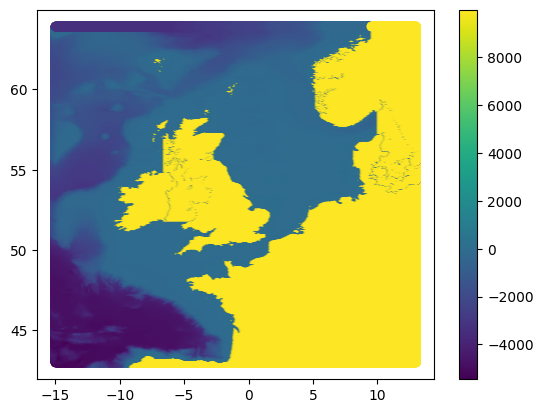

In [43]:
# Bottom grid

x0_b = -15
y0_b = 43
m_bot = 1120
n_bot = 1260
dx_bot = 0.025
dy_bot = 0.0166

x_bot = np.linspace(x0_b, x0_b + m_bot * dx_bot , m_bot + 1)
y_bot = np.linspace(y0_b, y0_b + n_bot * dy_bot , n_bot + 1)


xgr_bot, ygr_bot = np.meshgrid(x_bot, y_bot)

def read_swn_bot(filePath, idla=3, missing_value = 999):
    
    if idla==3:
        fid = open(filePath)
        dep = []
        while True:
            line = fid.readline()

            if (''==line):
                print('eof')
                break
            
            dep.append([float(x) for x in line[:-1].split()])

        dep = np.array(dep)
        dep[dep==missing_value] = np.nan
        return dep
    else:
        print('other idla\'s not yet scripted')


botfile = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\SWAN_Noordzee.bot'
dep = read_swn_bot(botfile, idla=3)
dep = dep * -1 
#%%
plt.scatter(xgr_bot[:], ygr_bot[:], c=dep[:])
plt.colorbar()

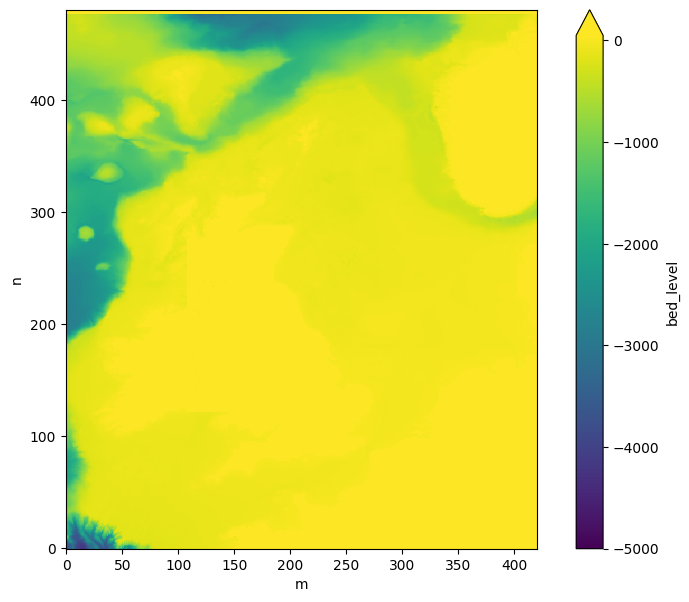

In [44]:
#%% create grid

# grid = RegularGrid(hw, specs['x0'], specs['y0'],
#                     specs['dx'], specs['dy'],
#                     specs['nmax'], specs['mmax'],  # mind you: the order here is n,m!
#                     specs['rotation'])

#% create bathy file
grid = HurryWaveGrid(hw)

hw.grid = grid
# model_builder = HurryWaveBuilder(hw, grid)

# model_builder.build(model_builder,
#               mskfile = "hurrywave.msk",
#               depfile = "hurrywave.dep",
#               make_mask=True,
#               get_bathymetry=True,
#               make_waveblockingfile = False,
#               make_tiles=True,
#               quiet=False)
# Get bathy/topo
# bathymetry = HurryWaveBathymetry(hw)

hw.grid.set_bathymetry_from_other_source(xgr_bot, ygr_bot, dep, rectilinearSourceData=False)

hw.grid.write_dep_file()
# hw.grid.set_bathymetry_from_other_source2(xgr_bot[0,:], ygr_bot[:,0], dep)
# xz, yz = grid.grid_coordinates_centres()
# plt.pcolor(xz, yz, bathymetry.z)
# plt.axis('equal')

# Save bathymetry
# bathymetry.save(os.path.join(hw.path, hw.input.variables.depfile))

fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds["bed_level"].plot(ax = ax, vmin = -5000, vmax = 50)

#%%


In [45]:
#% Mask 
# Initialize polygons as None
include_polygon = None
exclude_polygon = None
boundary_polygon = None

open_boundary_polygon = os.path.join(model_setup, "open_bound.pli")

polygons = read_pli_file(open_boundary_polygon)
polygon_list = []

for polygon in polygons:
    polygon_list.append(MaskPolygon(x=polygon.x,
                            y=polygon.y,
                            zmin=-9999,
                            zmax=1) ) 


# mask = HurryWaveMask(grid, bathymetry.z,
#             zmin= -9999,
#             zmax=0, 
#             open_boundary_polygons= polygon_list
#             )

# Convert polygon_list to a GeoDataFrame
polygon_geometries = [Polygon(zip(polygon.x, polygon.y)) for polygon in polygons]
polygon_gdf = gpd.GeoDataFrame({'geometry': polygon_geometries}, crs="WGS 84")
hw.grid.build_mask(
            zmin= -9999,
            zmax=0, 
            boundary_polygon= polygon_gdf
            )

hw.grid.write_msk_file()

# fig, ax = plt.subplots(1,1, figsize = (10,7))
# ax.set_aspect("equal")
# hw.grid.ds.mask.plot(ax = ax)
# hw.write()




In [48]:
wnd_file = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312061000.wnd'

def read_swn_wnd(filePath, x0inp, y0inp, rot, mxinp, myinp, dxinp, dyinp, idla=3, missing_value = 99):
    
    xx = dxinp*np.arange(0,mxinp+1)
    yy = dyinp*np.arange(0,myinp+1)

    xinp0, yinp0 = np.meshgrid(xx, yy)
    cosrot = np.cos(rot*np.pi/180)
    sinrot = np.sin(rot*np.pi/180)
    xinp = x0inp + xinp0*cosrot - yinp0*sinrot
    yinp = y0inp + xinp0*sinrot + yinp0*cosrot

    if idla==3:
        fid = open(filePath)
        wnd = []
        while True:
            line = fid.readline()

            if (''==line):
                print('eof', filePath)
                break
            
            wnd.append([float(x) for x in line[:-1].split()])

        #Create array with all values in single array
        
        wnds = []
        for wnd_idx in wnd:
            wnds += wnd_idx

        wnds = np.array(wnds)
        wnd[wnd==missing_value] = np.nan

        idxs_u = (myinp+1) * (mxinp+1)

        # wnd files have structure first all east-ward winds, than all northward winds
        wndu = wnds[:idxs_u]
        wndv = wnds[idxs_u:]

        #reshape

        wndu = wndu.reshape(myinp+1, mxinp+1)
        wndv = wndv.reshape(myinp+1, mxinp+1)
        
        return xinp, yinp, wndu, wndv
    else:
        print('other idla\'s not yet scripted')

import glob

wndu = []; wndv = [];
filez = glob.glob(r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\*.wnd')
for ix, wnd_file in enumerate(filez):
    xinp, yinp, wndui, wndvi = read_swn_wnd(wnd_file, x0inp=-12, y0inp=48, rot=0, mxinp=210, myinp=240, dxinp=0.1, dyinp=0.06667)
    
    # Add first wnd files 48 times to account for 2 extra days physical spinup

    extra_days = 2

    if ix == 0:
        for i in range(extra_days*24):
            wndu.append(wndui)
            wndv.append(wndvi)
        print(f"Add first wnd file {extra_days*24} times to account for physical spin-up")
    
    wndu.append(wndui)
    wndv.append(wndvi)


wu = np.stack(wndu,0)
wv = np.stack(wndv,0)
tstartinp = specs['tstart']
tstopinp = specs['tstop']
timeinp = pd.date_range(tstartinp, tstopinp, freq='1H')

#%%
class Dataset():

    def __init__(self, time, x, y, u, v, crs=CRS(4326)):

        self.quantity = []
        self.unit     = None  
        self.crs      = crs
        self.time     = time
        self.x        = x
        self.y        = y
        # self.u        = []
        # self.v        = []
        self.add_wind( u, v)

    class uvwind():

        def __init__(self, u, v):
            self.u        = u
            self.v        = v
            self.name     = 'wind'

    def add_wind(self, u, v):
        self.quantity.append(self.uvwind(u, v))

ds = Dataset(timeinp, xinp[0,:], yinp[:,0], wu, wv)
MeteoGrid.write_to_delft3d(ds, 'wind', parameters=['wind'], path=os.path.join(model_setup))

# wind forcing to input file
hw.input.update({'amufile': 'wind.amu', 'amvfile': 'wind.amv', 'tspinup': 1800.0})

#%% Boundary forcing files have been created with external matlab script: create_HurryWave_boundary_matlab.m (02-scripts)

extended = True


# Retrieve, rewrite and restore files

folder_bnd = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\matlab_generated'

df_bhs = pd.read_csv(os.path.join(folder_bnd, 'bnd_hm0.txt'), 
                     header = None, 
                     delim_whitespace=True)

df_btp =  pd.read_csv(os.path.join(folder_bnd, 'bnd_tps.txt'),
                       header = None, 
                       delim_whitespace=True)

df_bwd =  pd.read_csv(os.path.join(folder_bnd, 'bnd_dir.txt'),
                       header = None, 
                       delim_whitespace=True)

df_bds = pd.read_csv(os.path.join(folder_bnd, 'bnd_dspr.txt'),
                      header = None, 
                      delim_whitespace=True)

df_coor =  pd.read_csv(os.path.join(folder_bnd, 'hurrywave.bnd'),
                        header = None, 
                        delim_whitespace=True)

# For the extended (2 days), we are adjusting the boundary files by adding two more days of forcing

dfs = [df_bhs, df_btp, df_bwd, df_bds]
names = ["hurrywave.bhs", "hurrywave.btp", "hurrywave.bwd", "hurrywave.bds" ]

if extended:
    for df,name in zip(dfs, names):
        print(f"Extending with 2 days")
        df = pd.concat([pd.DataFrame(df.iloc[0]).T, df], ignore_index = True)
        df.iloc[1:, 0] = df.iloc[1:, 0] + 3600 * 24 * 2
        df.round(4).to_csv(os.path.join(model_setup, name ), sep=' ', header =  False, index = False)

    df_coor.to_csv(os.path.join(model_setup, "hurrywave.bnd" ), sep=' ', index = False, header =  False)
    
    # write to input file
    hw.input.update({'bhsfile': 'hurrywave.bhs', 'btpfile': 'hurrywave.btp', 
                 'bwdfile': 'hurrywave.bwd', 'bdsfile': 'hurrywave.bds', 
                 'bndfile': 'hurrywave.bnd',
                 })
    
else:
    print("Using original files")
    # save to csv
    df_bhs.round(4).to_csv(os.path.join(model_setup, "hurrywave.bhs" ), sep=' ', header =  False, index = False)
    df_btp.round(4).to_csv(os.path.join(model_setup, "hurrywave.btp" ), sep=' ', header =  False, index = False)
    df_bwd.round(4).to_csv(os.path.join(model_setup, "hurrywave.bwd" ), sep=' ', header =  False, index = False)
    df_bds.round(4).to_csv(os.path.join(model_setup, "hurrywave.bds" ), sep=' ', header =  False, index = False)
    df_coor.to_csv(os.path.join(model_setup, "hurrywave.bnd" ), sep=' ', index = False, header =  False)

    # write to input file
    hw.input.update({'bhsfile': 'hurrywave.bhs', 'btpfile': 'hurrywave.btp', 
                    'bwdfile': 'hurrywave.bwd', 'bdsfile': 'hurrywave.bds', 
                    'bndfile': 'hurrywave.bnd',
                    })


#%% Output

hw.input.update({'dtmapout': 1800, 'dthisout': 300, 'obsfile': 'hurrywave.obs'})
observation_points_swan_dir = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\f998dcs13001.pnt'

df_obs = pd.read_csv(observation_points_swan_dir, 
                     header = None, 
                     delim_whitespace=True)


df_obs.to_csv(os.path.join(model_setup, "hurrywave.obs" ), sep=' ', index = False, header =  False)




eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030000.wnd
Add first wnd file 48 times to account for physical spin-up
eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030100.wnd
eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030200.wnd
eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030300.wnd
eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030400.wnd
eof C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\wind\f998dcs13001_201312030500.wnd
eof 

C:\Users\User\AppData\Local\Temp\ipykernel_24456\3644811214.py:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timeinp = pd.date_range(tstartinp, tstopinp, freq='1H')


Extending with 2 days
Extending with 2 days
Extending with 2 days
Extending with 2 days


C:\Users\User\AppData\Local\Temp\ipykernel_24456\3644811214.py:117: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bhs = pd.read_csv(os.path.join(folder_bnd, 'bnd_hm0.txt'),
C:\Users\User\AppData\Local\Temp\ipykernel_24456\3644811214.py:121: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_btp =  pd.read_csv(os.path.join(folder_bnd, 'bnd_tps.txt'),
C:\Users\User\AppData\Local\Temp\ipykernel_24456\3644811214.py:125: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bwd =  pd.read_csv(os.path.join(folder_bnd, 'bnd_dir.txt'),
C:\Users\User\AppData\Local\Temp\ipykernel_24456\3644811214.py:129: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future v

In [49]:
#%% write the total model to file
hw.write()

# %%

In [ ]:
def run_model():
    batch_file = r"C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\NorthSeanobnd\run.bat"   
    batch_file = os.path.normpath(batch_file).replace("/", "\\")
    # Run the batch file and stream output live
    process = subprocess.Popen(
        [batch_file],
        shell=True,
        cwd=model_setup,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,  # Merge stderr into stdout (optional)
        text=True  # Auto-decodes bytes to strings
    )

    # Print output as it appears
    for line in process.stdout:
        print(line, end='')  # Already includes newline

    # Wait for process to finish
    process.wait()

In [ ]:
# run_model()


(hurrywave) C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\NorthSeanobnd>C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\06_executables\hurrywave\hurrywave.exe

---Welcome to HURRYWAVE---

Build-Revision: $Rev: xxx $
Build-Version: $Version: new netcdf libraries$
Build-Date: $Date: 2024-06-05$

Reading input file ...
 Reading hurrywave.dep
 Reading hurrywave.msk
      134718  active points
Initializing domain ...
Warning! Reducing dt from 300.0 s to 103.8 s
Reading amu and amv file ...
Reading wave boundary locations ...
Reading wave boundaries ...
 Input boundary points found:           22
Reading observation points ...
Running on 12 threads
Starting computation ...
   0% complete,       - s remaining ...
